<h1><center>Kats 204 Forecasting with Meta Learning</center></h1>

We proposed a meta-learning framework for forecasting predictability, model selection and hyper-parameters tuning (HPT) through a supervised learning perspective, which provides accurate forecasts with low computational time and resources. 

It first classifies whether a time series is predictable or not (i.e. whether we can get a good forecasts without much human-engineering efforts). Then it uses classification algorithm to predict the best forecasting model using the extracted time series features. Given the selected forecasting model, a multi-tasks neural network model is used to predict the best hyper parameters. 

The meta-learning framework contains four steps:

1. Meta-data collection:  tuning to obtain the best performed model for a given time series, and hyper-parameters for each model and data combination. 

2. Predict whether a time series is predicatable or not. This is an optional examination step, which aims to inform user whether the target time series can be easily fitted by a single model or additional human-engineering efforts are needed.

3. Predict forecasting model for the target time series.

4. Predict hyper-parameters for the target time series.

Kats provides APIs for all these steps.




## 1. **Meta-data collection**

This module extracts the meta-data of a time series, which includes:

1. The hyper-parameters and the corresponding forecasting errors of 6 best candidate models after hyper-parameter tuning; 

2. 40 time series features; 

3. Search method for hyper-parameter tuning (e.g., random search, grid search or Bayesian Optimal Search);

4. Error metrics used in evaluating hyper-parameters (MAE is defualt and MAPE is recommended.).

Paremeters for GetMetaData() class:
* **data**: TimeSeriesData
* **all_models**: Dict\[str, m.Model], a dictionary that includes all candidate models.
* **all_params**: Dict\[str, Params], a dictionary that includes all candidate parameter class corresponding to the candidate models.
* **min_length**: Optional; int, the minimal length of time series. Time series data whose length is shorter than min_length will be excluded.
* **scale**: bool, It indicates whether to rescale TS before computing the time series feature vector. If true, then the time series will be normalized by its max value.
* **method**: SearchMethodEnum, Search method for hyper-parameters tuning.
* **executor**: Any, A callable parallel executor. Tune individual model in candidate models parallel. The default executor is native implementation with Python's multiprocessing.
* **error_method**: str, Type of error metric. Only support mape, smape, mae, mase, mse, rmse.
* **num_trials**: optional, Number of trials in RandomSearch.
* **num_arm**: optional, Number of arms in RandomSearch.

### 1.1 Collect meta-data from a time series

In [1]:
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append("../")

from kats.consts import TimeSeriesData
from kats.models.metalearner.get_metadata import GetMetaData

#load data and transform it into TimeSeriesData
data = pd.read_csv("../kats/data/air_passengers.csv")
data.columns = ["time", "y"]
TSdata = TimeSeriesData(data)

# create an object MD of class GetMetaData
MD = GetMetaData(data=TSdata, error_method='mape')

# get meta data, as well as search method and type of error metric
my_meta_data = MD.get_meta_data()

ERROR:root:Feature vector contains NAN. features_dict {'length': 144, 'mean': 0.45064085387638453, 'var': 0.03694123647244219, 'entropy': 0.4287365561752448, 'lumpiness': 2.0317879601323604e-05, 'stability': 0.03180185085604344, 'flat_spots': 2, 'hurst': -0.08023291030513359, 'std1st_der': 0.043740012626144645, 'crossing_points': 7, 'binarize_mean': 0.4444444444444444, 'unitroot_kpss': 0.12847508180149347, 'heterogeneity': 126.06450625819339, 'histogram_mode': 0.2504823151125402, 'linearity': 0.8536381656031872, 'trend_strength': 0.9383301875692747, 'seasonality_strength': 0.3299338017939567, 'spikiness': 7.462446542148283e-10, 'peak': 6, 'trough': 3, 'level_shift_idx': 118, 'level_shift_size': 0.025080385852090048, 'y_acf1': 0.9480473407524915, 'y_acf5': 3.392072131604335, 'diff1y_acf1': 0.3028552581521692, 'diff1y_acf5': 0.25945910659994703, 'diff2y_acf1': -0.19100586757092758, 'diff2y_acf5': 0.13420736423784568, 'y_pacf5': 1.0032882494015267, 'diff1y_pacf5': 0.21941234780081384, 'di

ValueError: Feature vector contains NAN. features_dict {'length': 144, 'mean': 0.45064085387638453, 'var': 0.03694123647244219, 'entropy': 0.4287365561752448, 'lumpiness': 2.0317879601323604e-05, 'stability': 0.03180185085604344, 'flat_spots': 2, 'hurst': -0.08023291030513359, 'std1st_der': 0.043740012626144645, 'crossing_points': 7, 'binarize_mean': 0.4444444444444444, 'unitroot_kpss': 0.12847508180149347, 'heterogeneity': 126.06450625819339, 'histogram_mode': 0.2504823151125402, 'linearity': 0.8536381656031872, 'trend_strength': 0.9383301875692747, 'seasonality_strength': 0.3299338017939567, 'spikiness': 7.462446542148283e-10, 'peak': 6, 'trough': 3, 'level_shift_idx': 118, 'level_shift_size': 0.025080385852090048, 'y_acf1': 0.9480473407524915, 'y_acf5': 3.392072131604335, 'diff1y_acf1': 0.3028552581521692, 'diff1y_acf5': 0.25945910659994703, 'diff2y_acf1': -0.19100586757092758, 'diff2y_acf5': 0.13420736423784568, 'y_pacf5': 1.0032882494015267, 'diff1y_pacf5': 0.21941234780081384, 'diff2y_pacf5': 0.2610103428699485, 'seas_acf1': 0.6629043863684491, 'seas_pacf1': 0.15616955255589257, 'firstmin_ac': 8, 'firstzero_ac': 52, 'holt_alpha': 0.9999999850988388, 'holt_beta': nan, 'hw_alpha': nan, 'hw_beta': nan, 'hw_gamma': nan}.

In [2]:
# the components of metadata
my_meta_data.keys()

dict_keys(['hpt_res', 'features', 'best_model', 'search_method', 'error_method'])

In [17]:
TSfeature=pd.DataFrame(my_meta_data['features'], index=['value'])
#TSfeature.fillna(0, inplace=True)

In [3]:
# extract search method and error metric
print('Search method used is: ', my_meta_data['search_method'])

print('Error metric used is: ', my_meta_data['error_method'])

Search method used is:  RandomSearch
Error metric used is:  mape


In this tutorial, we pre-collected meta-data from m3 monthly data to demonstrate how to build and use meta-learning models. Notice that we are using a very small meta-data dataset (i.e., 78 records) and hence the performance of meta-learning models may not be ideal. In real applications, please considering using a relatively large meta-data dataset to ensure good performance.

In [6]:
# Preprocessing function
def change_format(tmp):
    tmp['hpt_res']=eval(tmp['hpt_res'])
    tmp['hpt_res']['sarima'][0]['seasonal_order'] = eval(tmp['hpt_res']['sarima'][0]['seasonal_order'])
    tmp['features']=eval(tmp['features'])
    return tmp


meta_data_df = pd.read_csv("../kats/data/m3_meta_data.csv")
meta_data = [change_format(meta_data_df.iloc[i].to_dict()) for i in range(len(meta_data_df))]

## 2. **Meta-learning Predictability (Optional)** 

Before using meta-learning models for model and hyper-parameters forecasting, we would like to know whether a target time series can be easily fitted by a simple model or should be taken care of by extra human efforts. If a time series is taken as unpredictable, then the results given by our meta-learning framework may not be satisfying. Whether a time series is predictable or not is defined by user via specifying the "threshold" parameter for a target error metric (i.e., the model will take the time series with error metric>=threshold as unpredicable). This step is optional.

Parameters for MetaLearnPredictability() class:
* **metadata**: Optional; A list of dictionaries representing the meta-data of time series (e.g., the meta-data generated by GetMetaData object).Each dictionary d must contain at least 3 components: 'hpt_res', 'features' and 'best_model'. d['hpt_res'] represents the best hyper-parameters for each candidate model and the corresponding errors;
d['features'] are time series features, and d['best_model'] is a string representing the best candidate model of the corresponding time series data. metadata should not be None unless load_model is True. Default is None

* **threshold**: Optional; A float representing the threshold for the forecasting error. A time series whose forecasting error of the best forecasting model is higher than the threshold is considered as unpredictable. Default is 0.2.

* **load_model**: Optional; A boolean to specify whether or not to load a trained model. Default is None.

In [11]:
# load class 
from kats.models.metalearner.metalearner_predictability import MetaLearnPredictability

#take the time series with MAPE>=0.2 as unpreditable time series and initial the object
mlp=MetaLearnPredictability(meta_data, threshold=0.2)

#train a meta-learning predictability model and display the evaluation metrics on the test_set
test_metrics=mlp.train()
print("evaluation on test_set: ", test_metrics)

#test whether TSdata is predictable or not
val=mlp.pred(TSdata)
val=(True if val==1 else False)
print("TSdata is predictable: {}".format(val))


evaluation on test_set:  {'accuracy': 0.8571428571428571, 'precision': 1.0, 'recall': 0.8, 'f1': 0.888888888888889}
TSdata is predictable: False
TSdata is predictable: True


## 3. **Meta-learn Model Selection**

The MetaLearnModelSelect object helps to predict which predictive model is the most suitable one for the target time series.

Parameters for MetaLearnModelSelect():
* **metadata**: Optional; A list of dictionaries representing the meta-data of time series (e.g., the meta-data generated by GetMetaData object). Each dictionary d must contain at least 3 components: 'hpt_res', 'features' and 'best_model'. d['hpt_res'] represents the best hyper-parameters for each candidate model and the corresponding errors; d['features'] are time series features, and d['best_model'] is a string representing the best candidate model of the corresponding time series data. metadata should not be None unless load_model is True. Default is None
* **load_model**: Optional; A boolean to specify whether or not to load a trained model. Default is False.



number of time series for each model:  Counter({'stlf': 22, 'sarima': 17, 'holtwinters': 16, 'arima': 11, 'prophet': 7, 'theta': 5})


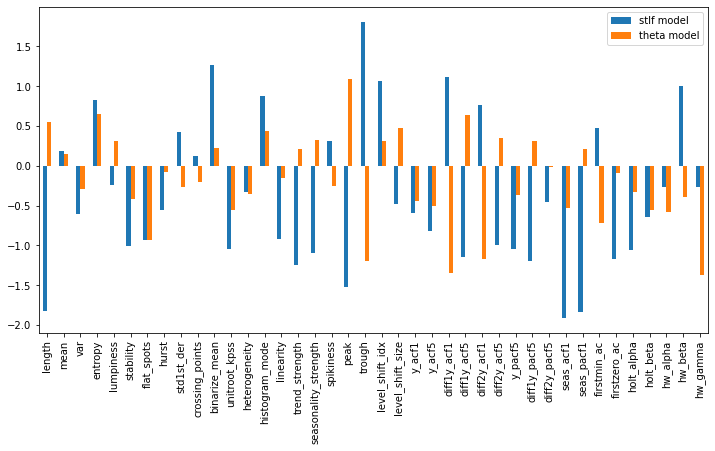

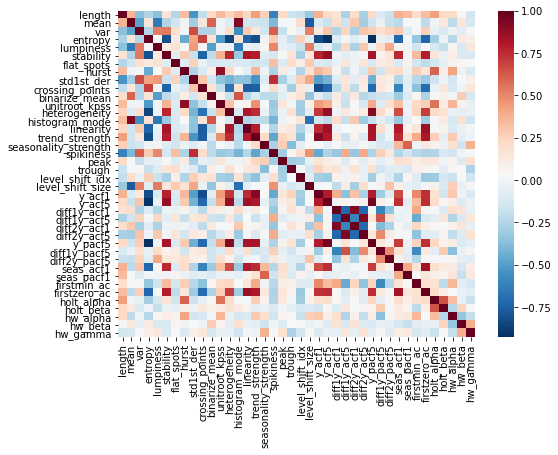

In [12]:
#load MetaLearnModelSelect
from kats.models.metalearner.metalearner_modelselect import MetaLearnModelSelect

#create an object mlms of class MetaLearnModelSelect
mlms = MetaLearnModelSelect(meta_data)

#get class info
counter=mlms.count_category()
print("number of time series for each model: ", counter)

#preprocessing meta-data: 
#not down-sample the meta-data to create the balanced data and standarized time series features to zero mean and unit standard deviation
mlms.preprocess(downsample=False, scale=True)

#generate features comparison plot
mlms.plot_feature_comparison(10, 35)

# generate heat map of correlation matrix of time series feature matrix
mlms.plot_corr_heatmap()

The meta-learning modelselect model is basically a multi-class classifier, and we currently support random foreset (default), GBDT, SVM, KNN, and naive Bayes. We also display the evaluation of the classifier in term of error metrics (i.e., MAPE for our example) on both the training set and test set, compared with the averaged error metric of using one model for all time series.

In [15]:
#train a modelselect model using random forest algorithm   
results=mlms.train()

#display evaluation metrics of MetaLearnModelSelect
summary=pd.DataFrame([results['fit_error'], results['pred_error']])
summary['type']=['fit_error', 'pred_error']
summary['error_metric']='MAPE'
summary


,meta-learn,stlf,arima,holtwinters,prophet,sarima,theta,type,error_metric
0,0.268805,0.311499,0.38010,0.352871,0.339043,0.313991,0.367037,fit_error,MAPE
1,0.260477,0.271855,0.23861,0.271329,0.232066,0.225798,0.303543,pred_error,MAPE


In [19]:
#predict forecasting model for a new time series data
pred_model = mlms.pred(TSdata)
print('Predicted forecasting model of this given time series data is: ', pred_model)


Predicted forecasting model of this given time series data is:  prophet


In [20]:
#save trained model and load a pre-trained model
mlms.save_model("mlms.pkl")

#initiate a new object and load the trained model
mlms2 = MetaLearnModelSelect(load_model=True)
mlms2.load_model("mlms.pkl")

#predict forecasting model with new MetaLearnModelSelect object
pred_model = mlms2.pred(TSdata)
print('Predicted forecasting model of this given time series data is: ', pred_model)

Predicted forecasting model of this given time series data is:  prophet


## 4. **Meta-learning Hyper-parameter Selection**

The MetaLearnHPT model generates the suitable hyper-parameters for a target time series given a designated model. We train a multi-task neural network using the optimal hyper-parameters from the meta-data and use it to predict the hyper-parameters.

Some importand parameters for MetaLearnHPT():
* **data_x**: Optional; A pd.DataFrame of time series features. data_x should not be None unless load_model is True. Default is None.
* **data_y**: Optional; A pd.DataFrame of the corresponding best hyper-parameters. data_y should not be None unless load_model is True. Default is None.
* **categorical_idx**: Optional; A list of strings of the names of the categorical hyper-parameters. Default is None.
    If there is no categorical variable, then set categorical_idx as empty list.
* **numerical_idx**: Optional; A list of strings of the names of the numerical hyper-parameters. Default is None.
    If there is no numerical variables, then set numerical_idx as an empty list.
* **default_model**: Optional; A string of the name of the forecast model whose default settings will be used. Can be 'arima', 'sarima', 'theta', 'prophet', 'holtwinters', 'stlf' or None. Default is None.
    If None, then a customized model will be initiated.
* **load_model**: Optional; A boolean to specify whether or not to load a trained model. Default is False.

In [21]:
# transform meta-data into pd.DataFrame
mlhpt_table={}
for m in ['arima', 'sarima', 'stlf', 'theta', 'prophet', 'holtwinters']:
    mlhpt_table[m]={'x':[], 'y':[]}
    for elm in range(len(meta_data)):
        mlhpt_table[m]['x'].append(meta_data[elm]['features'])
        mlhpt_table[m]['y'].append(meta_data[elm]['hpt_res'][m][0])

for tab in mlhpt_table:
    mlhpt_table[tab]['x']=pd.DataFrame(mlhpt_table[tab]['x'])
    mlhpt_table[tab]['y']=pd.DataFrame(mlhpt_table[tab]['y'])
    
#load MetaLearnHPT
from kats.models.metalearner.metalearner_hpt import MetaLearnHPT



### 4.1 MetaLearnHPT with default NNs

For the users who want to avoid specifying the types of hyper-parameters and the neural network structures, we provide user-friendly default neural network structures.

Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=20, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=20, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=20, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=2, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=6, bias=True)
    )
  )
  (num_layer): ModuleList()
)


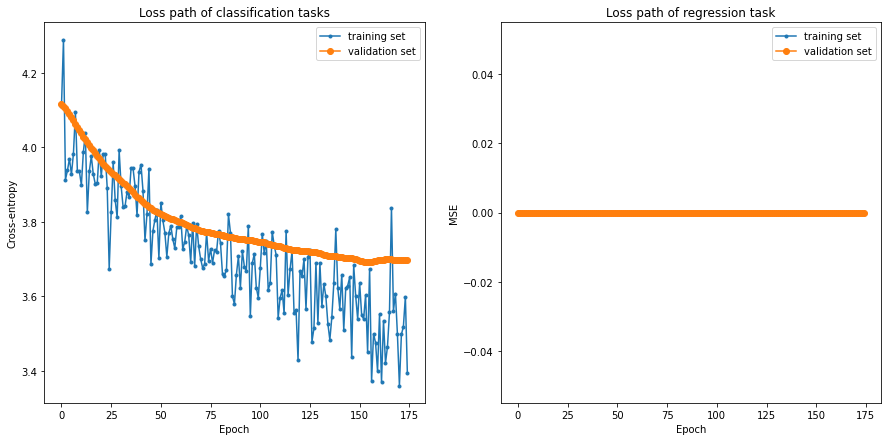

In [24]:
#create an object using our default neural network (take Holt-Winter's model as an example)
tab='holtwinters'
mlhpt_holtwinters = MetaLearnHPT(
    data_x=mlhpt_table[tab]['x'],
    data_y=mlhpt_table[tab]['y'],
    default_model=tab
)

#build a multi-task neural network using our default NN structure
mlhpt_holtwinters.build_network()

#train the multi-task NN
mlhpt_holtwinters.train(lr=0.001, batch_size=20)

#plot the training curves
mlhpt_holtwinters.plot()

In [25]:
#predict hyper-parameters using TimeSeriesData
pred=mlhpt_holtwinters.pred(TSdata)
print("predict hyper-parameters: ", pred['parameters'].iloc[0])


predict hyper-parameters:  {}


In [26]:
#save the trained model
mlhpt_holtwinters.save_model("mlhpt_hw.pkl")

#initiate a new object to load the trained model
mlhpt2=MetaLearnHPT(load_model=True)
mlhpt2.load_model("mlhpt_hw.pkl")

#get prediction using the new object
pred=mlhpt2.pred(TSdata)
print("predict hyper-parameters: ", pred['parameters'].iloc[0])

predict hyper-parameters:  {}


### 4.2 MetaLearnHPT with customized NNs

We also give users the flexibility to specify their own NNs. 

Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=50, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (num_layer): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=1, bias=True)
  )
)


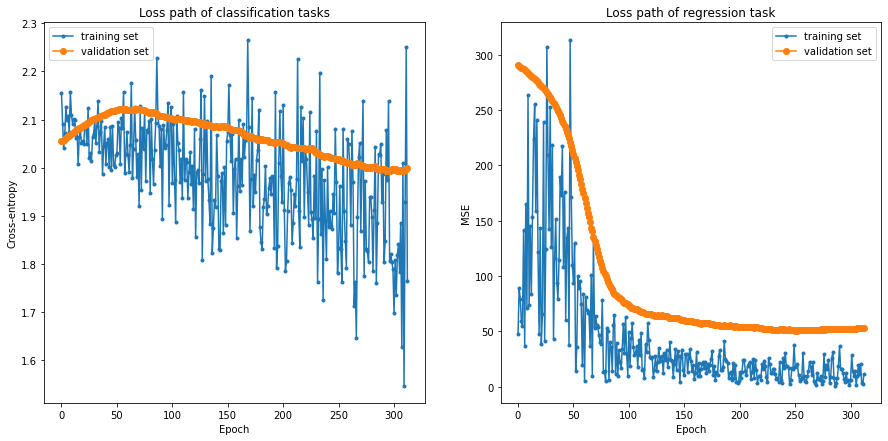

In [27]:
#create an object with customized structures (take Holt-Winter's model as an example).
mlhpt_holtwinters=MetaLearnHPT(
    data_x=pd.DataFrame(mlhpt_table[tab]['x']),
    data_y=pd.DataFrame(mlhpt_table[tab]['y']),	
    #specify the names of cateogrical label
    categorical_idx = [
                        "trend",
                        "damped",
                        "seasonal",
                    ],
    #specify the names of continuous label
    numerical_idx = ["seasonal_periods"]
    
)

#build the customized NN
mlhpt_holtwinters.build_network(
    #One shared one-layer NN with 50 neurons.
    n_hidden_shared=[50],
    #Each classification task has its own task-specific NN. In this example, "trend" and "dampled" both have a two-layer NN respectively
    #and "seasonal" has a one-layer NN.
    n_hidden_cat_combo=[[20, 10], [20, 10], [20]], 
    #One task-specific one-layer NN with 30 neurons for regression task.
    n_hidden_num=[30]
)

#train the customized NN
mlhpt_holtwinters.train(    
    #loss_scale is used to balance 2 types of losses: cross-entropy for classification tasks and MSE for regression tasks
    loss_scale=30,
    #learning rate
    lr=0.005,
    n_epochs=2000,
    batch_size=16,
    #supports ADAM and SGD
    method='SGD',
    #momentum in SGD.
    momentum=0,
    #early stop option.
    n_epochs_stop=50,)

#plot the training curves
mlhpt_holtwinters.plot()

In [28]:
# make a prediction
mlhpt_holtwinters.pred(TSdata)
print("predict hyper-parameters: ", pred['parameters'].iloc[0])

predict hyper-parameters:  {}
